# Supervised Classification: Lithology Classification with Well Logs

**Well log interpretation is a critical yet time-intensive task in subsurface exploration, requiring geoscientists to analyze complex datasets to infer lithology accurately. Developing an automated solution that can instantly and accurately classify lithology has significant implications for the efficiency and effectiveness of geological workflows. This project aims to address this challenge by leveraging machine learning to interpret lithology from various well logs provided from the FORCE 2020 ML competition. By utilizing logs with pre-labeled lithology data, the goal is to examine whether a robust and effective machine learning model can be developed to classify lithology reliably, streamlining interpretation and supporting more informed decision-making in geoscience applications.**

## Project Setup

### Import Libraries

In [87]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
!pip install lasio
import lasio

### Import and Clean Data

In [88]:
# List of LAS file URLs (update with the actual repository's raw file URLs)
las_files = [
    "https://raw.githubusercontent.com/ed3894/GEOL-558A/main/Supervised%20Classification/Well%20Logs/15_9-14.las",
    "https://raw.githubusercontent.com/ed3894/GEOL-558A/main/Supervised%20Classification/Well%20Logs/15_9-15.las",
    "https://raw.githubusercontent.com/ed3894/GEOL-558A/main/Supervised%20Classification/Well%20Logs/15_9-17.las",
]

# Columns to remove
columns_to_remove = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'CALI', 'MUDWEIGHT', 'ROP', 'RDEP', 'RSHA', 'RMED', 'RXO', 'X_LOC', 'Y_LOC', 'Z_LOC', 'Source', 'BS', 'DCAL', 'DCAL', 'SGR', 'ROPA', 'DTS', 'DRHO']

# Initialize an empty list to store DataFrames
dataframes = []

# Read LAS files
for i, las_url in enumerate(las_files):
    try:
        las = lasio.read(las_url)
        df = las.df()
        if not df.empty:
            df['Source'] = os.path.basename(las_url)  # Track file origin
            df['Well_ID'] = i  # Add a Well ID
            dataframes.append(df)
        else:
            print(f"No data found in file: {las_url}")
    except Exception as e:
        print(f"Error reading file {las_url}: {e}")

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Drop the specified columns first
combined_df = combined_df.drop(columns=[col for col in columns_to_remove if col in combined_df.columns], errors='ignore')

# Drop rows where Nan values are present
cleaned_df = combined_df.dropna()

# Remove rows where any of the specified columns have negative values
columns_to_check = ['PEF', 'GR', 'RHOB', 'DTC', 'NPHI']
cleaned_df = cleaned_df[(cleaned_df[columns_to_check] >= 0).all(axis=1)]


### Fix Lithology labels

In [89]:
# Define the lithology keys
lithology_keys = {
    30000: 'Sandstone',
    65030: 'Sandstone/Shale',
    65000: 'Shale',
    80000: 'Marl',
    74000: 'Dolomite',
    70000: 'Limestone',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Anhydrite',
    99000: 'Tuff',
    90000: 'Coal',
    93000: 'Basement'
}

# Ensure the DataFrame is a copy to avoid SettingWithCopyWarning
cleaned_df = cleaned_df.copy()

# Create a new column 'Lithology' by mapping the lithology codes to descriptions
cleaned_df.loc[:, 'Lithology'] = cleaned_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys).astype(str)

# Remove rows where Lithology is Chalk or Dolomite
cleaned_df = cleaned_df[~cleaned_df['Lithology'].isin(['Chalk', 'Dolomite'])]

# Reset the index of the DataFrame, starting from 0
cleaned_df = cleaned_df.reset_index(drop=True)

# Print the final cleaned DataFrame
print("Final DataFrame shape:", cleaned_df.shape)

# Print the first few rows to confirm
print("----------------------------------------------")
print('First Few Rows:')
print(cleaned_df.head())

Final DataFrame shape: (41455, 10)
----------------------------------------------
First Few Rows:
   FORCE_2020_LITHOFACIES_LITHOLOGY         SP         DTC      NPHI  \
0                           65000.0  35.525719  174.347092  0.551575   
1                           65000.0  36.158520  176.112915  0.547566   
2                           65000.0  36.873703  177.662476  0.551840   
3                           65000.0  37.304054  177.437714  0.552511   
4                           65000.0  37.864922  176.797653  0.566789   

         PEF         GR      RHOB    DEPTH_MD  Well_ID Lithology  
0  55.815659  72.078377  2.171173  480.627991        0     Shale  
1  41.862537  72.147697  2.171840  480.779999        0     Shale  
2  38.587872  75.074219  2.161303  480.932007        0     Shale  
3  41.417999  80.735229  2.151947  481.084015        0     Shale  
4  49.471237  81.665024  2.143010  481.235992        0     Shale  


**My data importation is relatively straight forward. For each well, I am assigning a number to reference back to the well. As I import each .las file, I remove any columns I don't want to analyze, then append all of those values to one large dataframe. Once that dataframe containing all of the well data is created, I remove rows with Nan values. This ensures I can analyze all of the pertinent wells at any given row. I also remove rows where there is an unrealistic value, such as negative density values. The lithology labels are numbers, but I want the labels to be more intuitive, so I am implementing a dictionary to convert those to text. This will make interpretations much easier later on. This data cleaning process has left me with 41,455 rows and 10 columns, which should be more than enough for data analysis. However, by today's standards I wouldn't call this "big data" as it is purely numerical and doesn't take up very much memory.**

## EDA

### Data Statistics

In [100]:
# Calculate pertinent stats of cleaned data
cleaned_df.describe()

,FORCE_2020_LITHOFACIES_LITHOLOGY,SP,DTC,NPHI,PEF,GR,RHOB,DEPTH_MD,Well_ID
count,41455.000000,41455.000000,41455.000000,41455.000000,41455.000000,41455.000000,41455.000000,41455.000000,41455.000000
mean,61508.604270,51.442169,125.173814,0.407831,3.581787,57.463222,2.126309,1962.410518,0.926933
std,13473.114655,25.123258,30.274401,0.126090,3.505604,25.241526,0.210741,673.387710,0.834782
min,30000.000000,7.232959,7.415132,0.018600,1.202017,5.951932,1.396819,480.627991,0.000000
25%,65000.000000,34.333445,96.003819,0.314942,2.285261,42.110846,1.986679,1439.753052,0.000000
50%,65000.000000,39.734932,137.082855,0.457444,2.973038,59.234119,2.063163,1964.823975,1.000000
75%,65030.000000,66.514748,147.821701,0.500660,4.130616,72.624287,2.268880,2514.620972,2.000000
max,99000.000000,137.085587,205.208664,0.733152,232.342529,804.298950,2.906611,3198.760010,2.000000


**The dataset contains 41,455 rows of well log data with various features like SP, DTC, NPHI, PEF, GR, RHOB, and depth. The lithology codes (FORCE_2020_LITHOFACIES_LITHOLOGY) range from 30,000 to 99,000, with a mean value of 61,508, indicating the prevalence of certain lithologies such as shale (65,000). Key features like SP and GR show wide variation, with GR ranging from 5.95 to 804.30, suggesting diverse lithological conditions. The mean DTC (125.17) and RHOB (2.13) are within typical ranges for subsurface logs, and NPHI shows a mean of 0.41). Depth spans from 481 to 3199 meters, covering a broad range of geological intervals, with wells fairly evenly distributed across the three well IDs. Overall, the data provides a comprehensive and diverse set of measurements suitable for lithology classification.**

### Seaborn Pair Plot

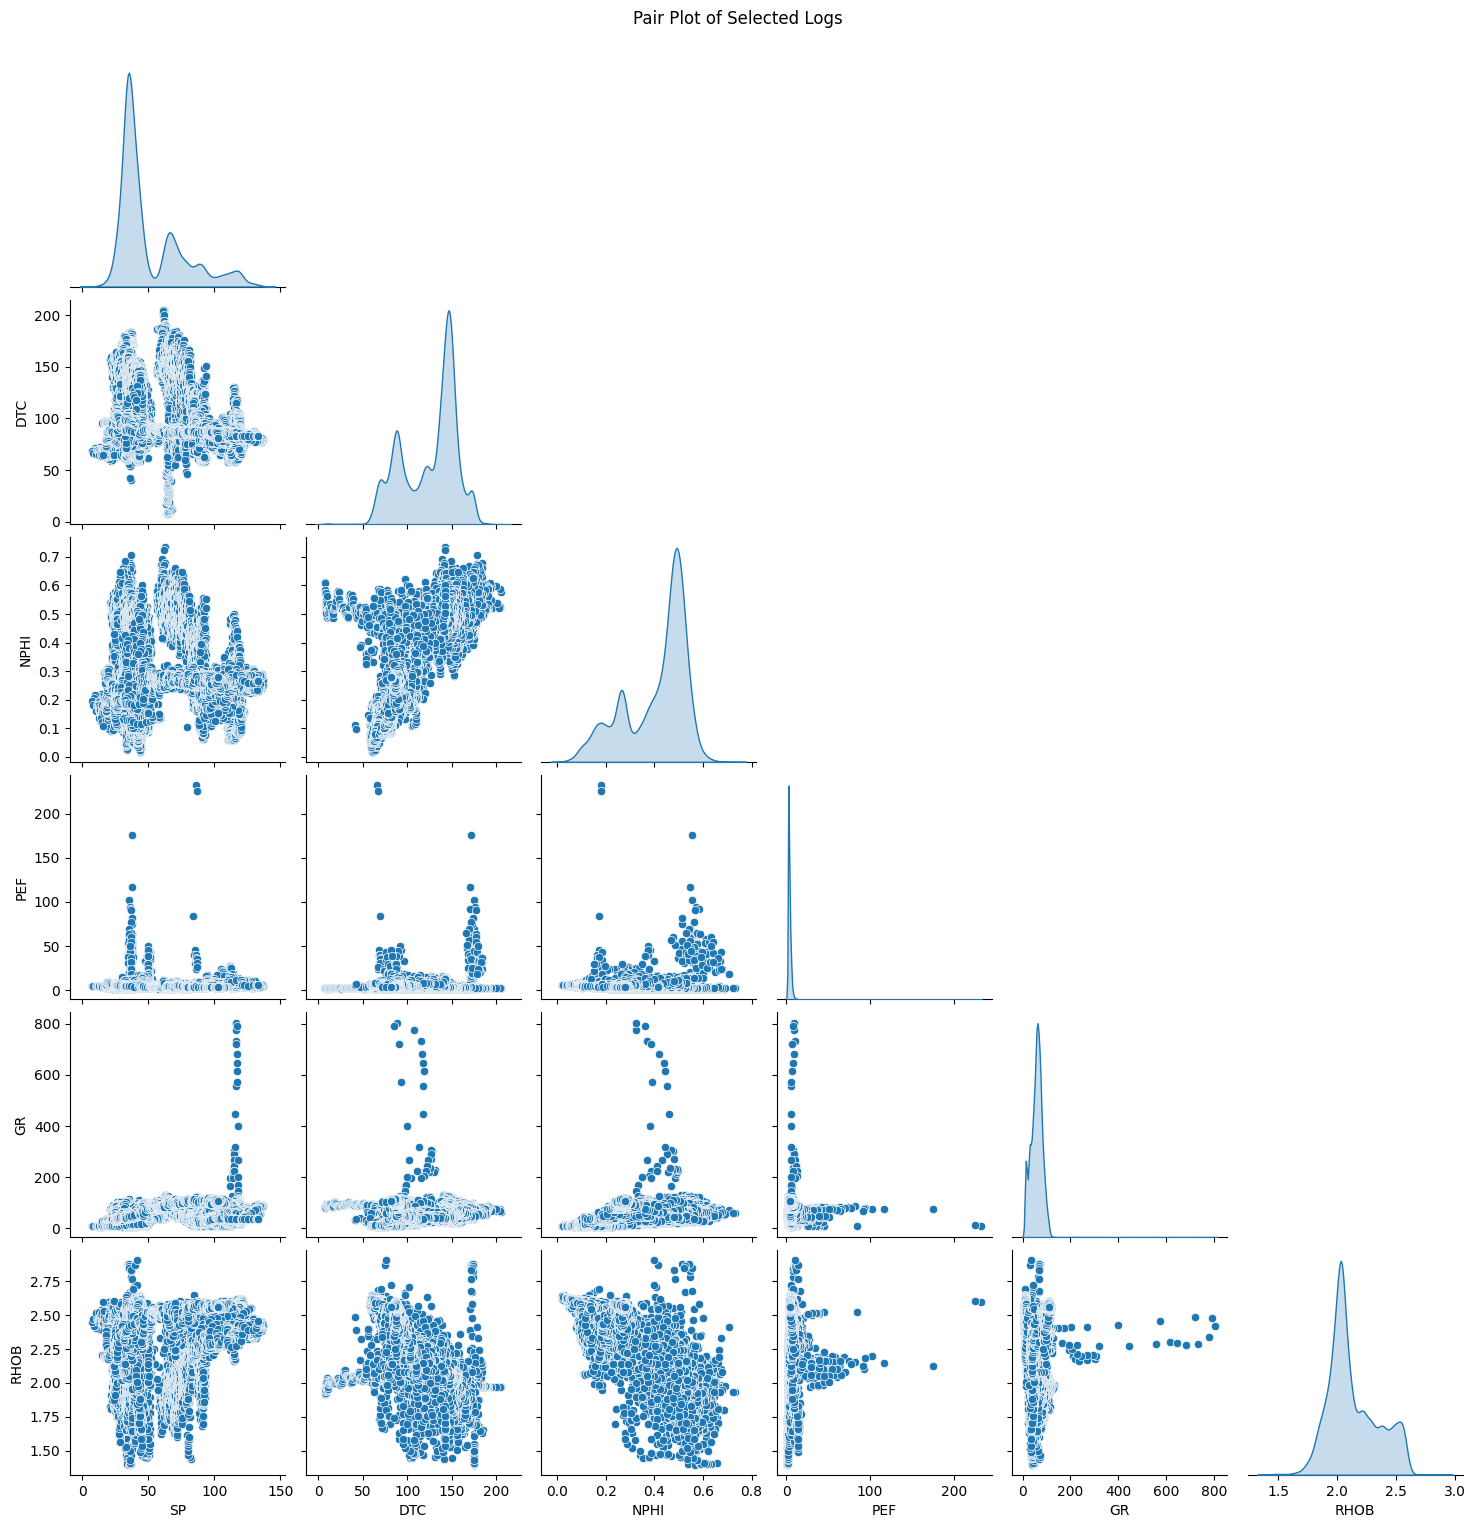

In [91]:
# Select the columns of interest
columns_to_plot = ['SP', 'DTC', 'NPHI', 'PEF', 'GR', 'RHOB']
df_to_plot = cleaned_df[columns_to_plot].dropna()  # Drop NaN values for these columns

# Create a pair plot
sns.pairplot(df_to_plot, diag_kind='kde', corner=True)

# Display the plot
plt.suptitle('Pair Plot of Selected Logs', y=1.02)
plt.show()

**A lot of the trends we see in the seaborn plots are consistent with what we would expect from well logs. For example, as NPHI increases, RHOB tends to decrease. Another place we see familiar trends is with RHOB, NPHI, and DTC. As DTC increases, RHOB tends to decrease and NPHI tends to increase, which we would expect. I also see that SP seems to form two clusters when combined with RHOB, NPHI, and DTC.  In GR and PEF logs, we see some large outliers which I will examine later on in this EDA. I also saw some interesting distributions which I will look at more closely later on.**

### Correlation Matrix Heatmap

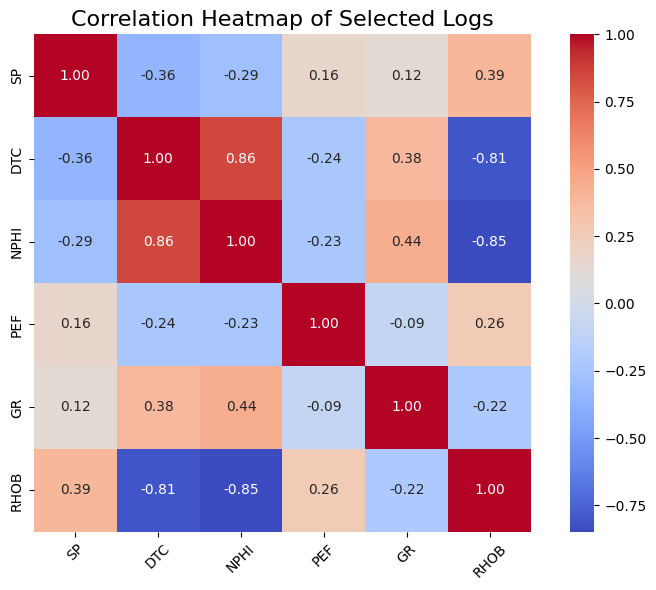

In [92]:
# Compute the correlation matrix
correlation_matrix = df_to_plot.corr()

# Set up the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

# Add labels and title
plt.title('Correlation Heatmap of Selected Logs', fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Display the plot
plt.show()

**As previously seen in the seaborn plots, the strongest trends are present between RHOB, DTC, and PHI. DTC and NPHI exhibit a positive trend, as both increase in formations with higher porosity, where sound waves travel slower due to fluid-filled pore spaces. On the other hand, DTC and RHOB show a negative trend, as denser rocks allow faster sound wave travel (lower DTC) while also exhibiting higher bulk density (higher RHOB). These trends are consistent with the physical properties of rock formations and their response to acoustic and density logging tools. Besides the aforementioned trends, none of the other trends are as strong, which is consistent with the seaborn plots.**

### Data Distributions

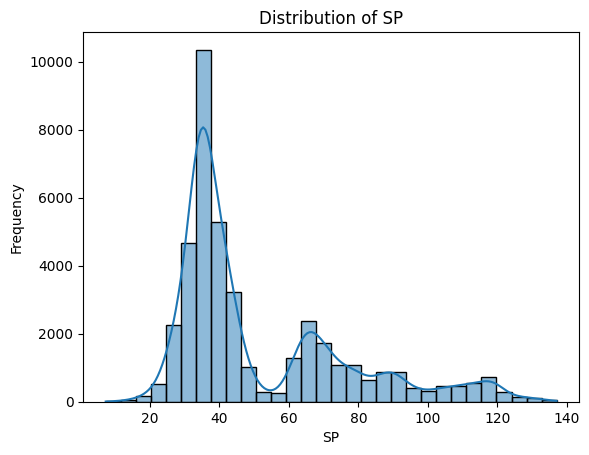

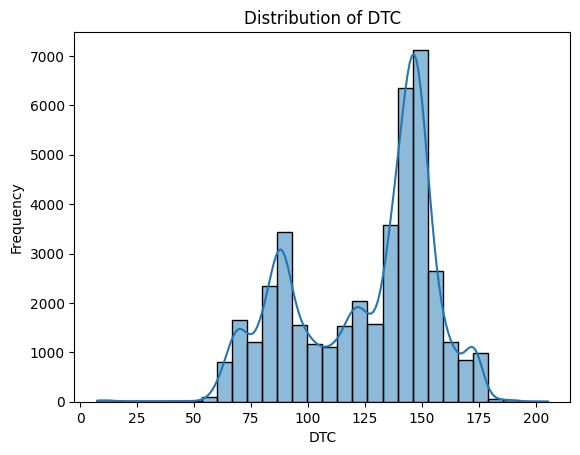

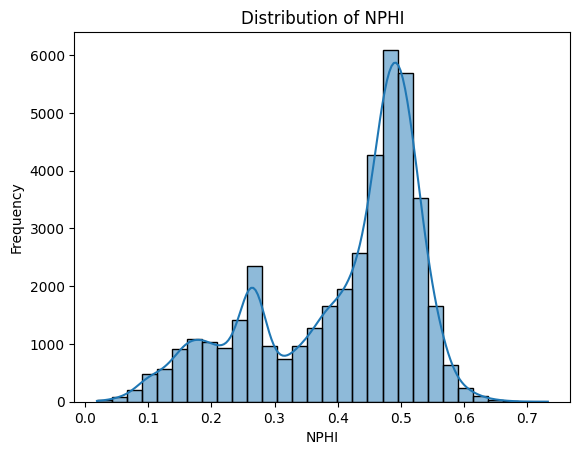

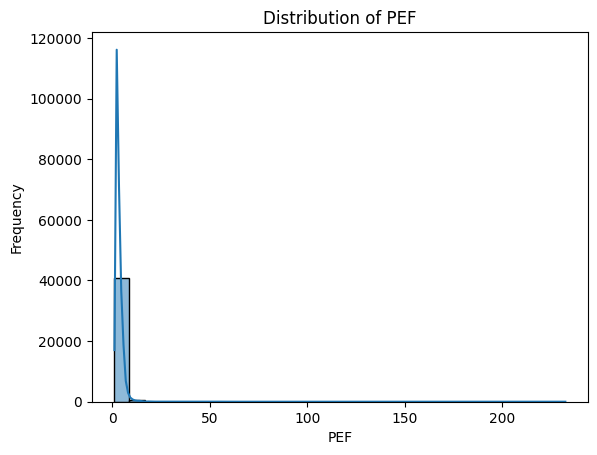

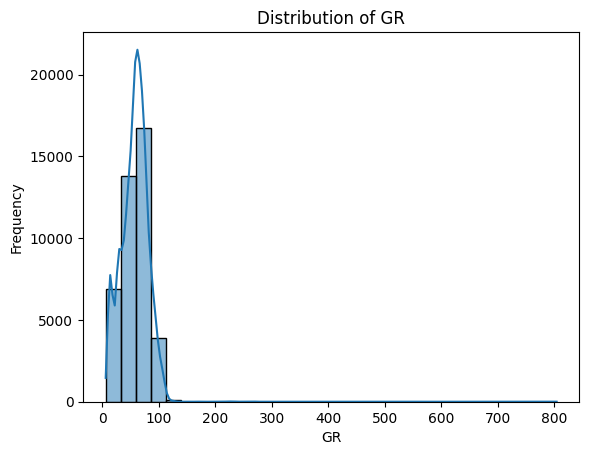

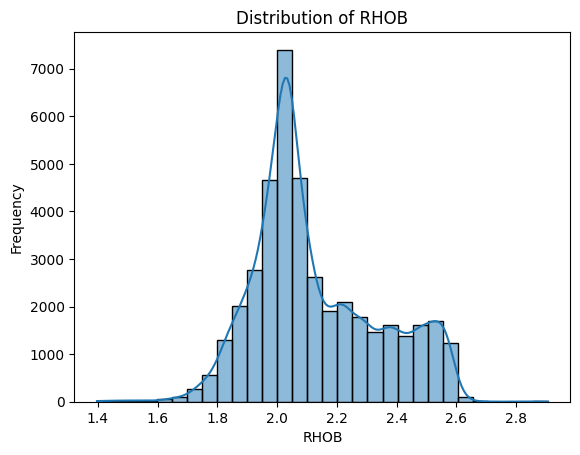

In [93]:
# Plot data distributions
for col in ['SP', 'DTC', 'NPHI', 'PEF', 'GR', 'RHOB']:
    sns.histplot(cleaned_df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

**Reexamining the distributions of each log showed some really interesting trends. SP, DTC, NPHI, and RHOB have more bimodal distributions, while PEF and GR have more unimodal distributions. This makes sense for PEF and GR, as the vast majority of values are closer to 0, with the exception of some outliers. I am not completely sure why we see bimodal distributions with the others, but I think that they could represent the two dominanat lithologies present across these logs.**

### Outlier Analysis


Outliers in SP: 1435
Outlier value range for SP: [114.78932953, 137.08558655]

Outliers in DTC: 40
Outlier value range for DTC: [7.4151320457, 17.917024612]

Outliers in NPHI: 15
Outlier value range for NPHI: [0.0186000001, 0.0349861868]

Outliers in PEF: 1605
Outlier value range for PEF: [6.9007697105, 232.3425293]

Outliers in GR: 65
Outlier value range for GR: [118.67471313, 804.2989502]

Outliers in RHOB: 92
Outlier value range for RHOB: [1.3968189955, 2.9066109657]


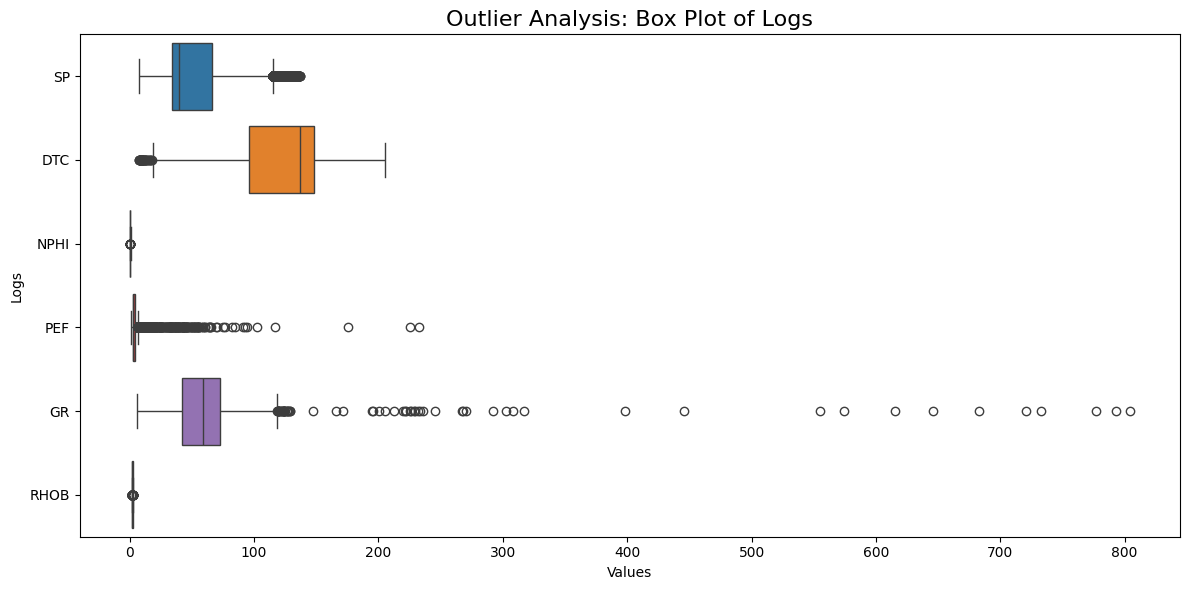

In [94]:
# Outlier analysis with outlier ranges
for col in ['SP', 'DTC', 'NPHI', 'PEF', 'GR', 'RHOB']:
    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = cleaned_df[(cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)]

    # Print the results
    print(f'\nOutliers in {col}: {len(outliers)}')
    if not outliers.empty:
        print(f'Outlier value range for {col}: [{outliers[col].min()}, {outliers[col].max()}]')
    else:
        print(f'No outliers detected in {col}.')

# Columns to analyze
columns_to_analyze = ['SP', 'DTC', 'NPHI', 'PEF', 'GR', 'RHOB']

# Set up the plot
plt.figure(figsize=(12, 6))

# Create a boxplot for each column
sns.boxplot(data=cleaned_df[columns_to_analyze], orient="h", showfliers=True)

# Add titles and labels
plt.title('Outlier Analysis: Box Plot of Logs', fontsize=16)
plt.xlabel('Values')
plt.ylabel('Logs')
plt.tight_layout()

# Display the plot
plt.show()

**The outlier analysis gives more insight into some of the trends we saw in the seaborn plots, and what we would expect from these logs in general. NPHI and RHOB didn't really have many large outliers, which makes sense as NPHI is measured between 0 and 1. While RHOB doesn't have a definitive range, values generally lie between 1-4 g/cc, and it is unlikely there will be outliers beyond that range. With PEF and GR, we see that most of the Gamma Ray values are around 50, and then there are quite a few outliers way higher than this range. With PEF, most of the values are around 0, and then we have a lot of outliers beyond this range. With SP, there are also a lot of outliers, except they are signficantly closer to the expected range when compared to SP and GR. Lastly, DTC doesn't have many otuliers, and follows a more normal distribution.**

##ML Analysis

### Import Libraries

In [95]:
# Import libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

### Split Data

In [96]:
# Split the data into training and testing sets based on Well_ID
train_wells = [0, 1]  # Well IDs for training
test_wells = [2]         # Well IDs for testing

# Training data: rows where Well_ID is in train_wells
train_df = cleaned_df[cleaned_df['Well_ID'].isin(train_wells)]

# Testing data: rows where Well_ID is in test_wells
test_df = cleaned_df[cleaned_df['Well_ID'].isin(test_wells)]

# Separate features and target for training and testing
features = ['SP', 'DTC', 'NPHI', 'PEF', 'GR', 'RHOB']
target = 'Lithology'  # Ensure this column is properly labeled and encoded

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Print shapes to verify
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")
print(f'Training: {X_train.shape[0]/(X_train.shape[0]+X_test.shape[0])*100}% of total data points')
print(f'Testing: {X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])*100}% of total data points')

print('--------------------------------------')

print("Training Class Distribution:\n", y_train.value_counts())
print("Testing Class Distribution:\n", y_test.value_counts())

Training data shape: (28415, 6), (28415,)
Testing data shape: (13040, 6), (13040,)
Training: 68.54420455916053% of total data points
Testing: 31.455795440839463% of total data points
--------------------------------------
Training Class Distribution:
 Lithology
Shale              13411
Sandstone/Shale     7303
Sandstone           4587
Limestone           2149
Marl                 597
Tuff                 368
Name: count, dtype: int64
Testing Class Distribution:
 Lithology
Shale              9650
Limestone          1481
Sandstone          1094
Tuff                320
Sandstone/Shale     270
Marl                225
Name: count, dtype: int64


**I chose to split up my data on a well basis. This represents a far more realistic scenario for this project. Presumably, an interpreter could mark lithologies in a few wells, and train the model on that. Then, they could use that model elsewhere in the basin/similar geographic region to get lithology. This method of training on two wells, and testing on one yields a 69/31% training and testing split, which is consistent with what is recommended for the following supervised methods. I also chose to show the quantity of each lithology in the training/testing data. This is important context, for my following supervised ML interpretations, as less common lithologies like marl and tuff may not perform as strong as shale which has the most data to train and test with.**

### Gradient Boosting Classifier

Classification Report:
                 precision    recall  f1-score   support

      Limestone       0.67      0.72      0.70      1481
           Marl       0.18      0.10      0.13       225
      Sandstone       0.66      0.83      0.74      1094
Sandstone/Shale       0.02      0.51      0.05       270
          Shale       0.95      0.39      0.55      9650
           Tuff       0.58      0.66      0.62       320

       accuracy                           0.47     13040
      macro avg       0.51      0.53      0.46     13040
   weighted avg       0.86      0.47      0.57     13040



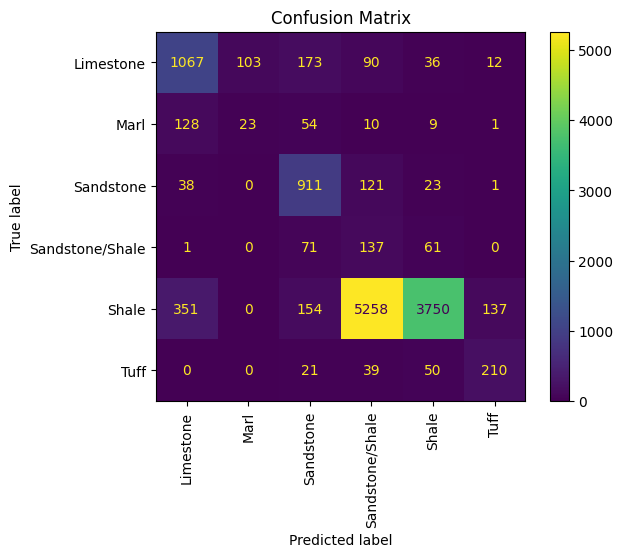

<ipython-input-97-e3ebd2b75891>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette="coolwarm")


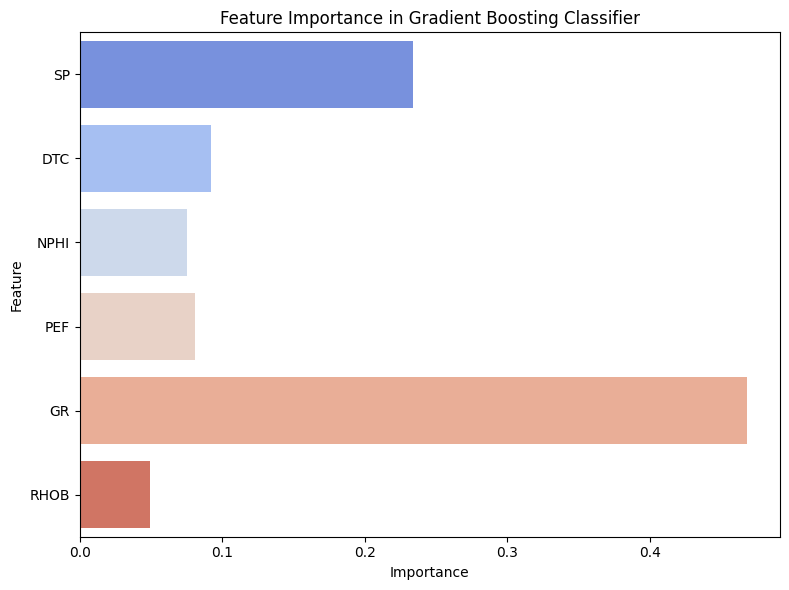

In [97]:
# Train the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gbc.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted(y_test.unique()))
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Feature Importance Plot
feature_importances = gbc.feature_importances_
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=features, palette="coolwarm")
plt.title("Feature Importance in Gradient Boosting Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**The gradient booster classifier did the best with Limestone, Sandstone, Shale, and Tuff, while Marl and Sandstone/Shale were the worst (as indicated by the f1 scores). Shale would have been higher with a 0.95 precision, but the recall was quite low which brought down the f1-score. The other ones with higher f1-scores generally had more consistent precision and recall. Overall the accuracy was quite low at 0.47. It is important to consider that this accuracy number is overall, so it will be dominated by lithologies with more data points present.**

**For the importance plot, I was expecting GR to be the most important since the underlying physics make it best for lithology identification. This prediction was consistent with the data. I thought RHOB, NPHI, or PEF would be the next most important. However, I was surprised to see SP. SP logs are derived from drilling and formation fluid interactions, and there can be a lot of mitigating variable. Additionally, they often tell us more about permeability and fluids rather than lithology. I think the reason it is so high is that shale is often impermeable, while sandstone is the opposite, which SP would be able to differentiate.**

### K Nearest Neighbors Clustering

Training KNN for SP vs DTC...
Classification Report for SP vs DTC:
                 precision    recall  f1-score   support

      Limestone       0.53      0.57      0.55      1481
           Marl       0.13      0.15      0.14       225
      Sandstone       0.26      0.72      0.38      1094
Sandstone/Shale       0.01      0.12      0.01       270
          Shale       0.88      0.28      0.43      9650
           Tuff       0.40      0.22      0.28       320

       accuracy                           0.35     13040
      macro avg       0.37      0.34      0.30     13040
   weighted avg       0.74      0.35      0.42     13040



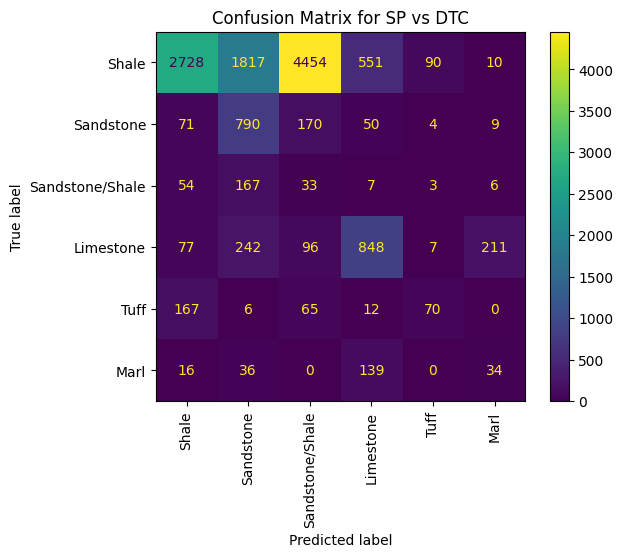

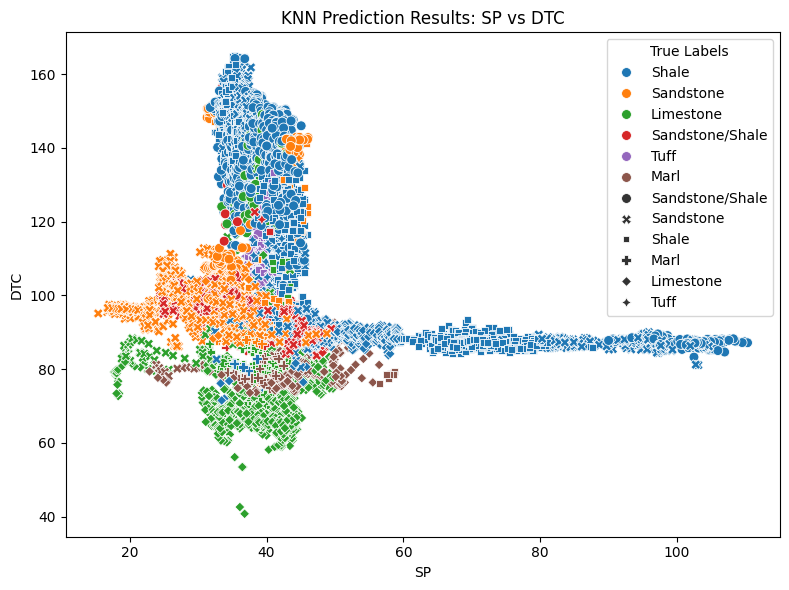

Training KNN for SP vs NPHI...
Classification Report for SP vs NPHI:
                 precision    recall  f1-score   support

      Limestone       0.55      0.65      0.59      1481
           Marl       0.08      0.11      0.10       225
      Sandstone       0.21      0.45      0.28      1094
Sandstone/Shale       0.01      0.11      0.01       270
          Shale       0.91      0.38      0.54      9650
           Tuff       0.41      0.31      0.35       320

       accuracy                           0.40     13040
      macro avg       0.36      0.34      0.31     13040
   weighted avg       0.76      0.40      0.50     13040



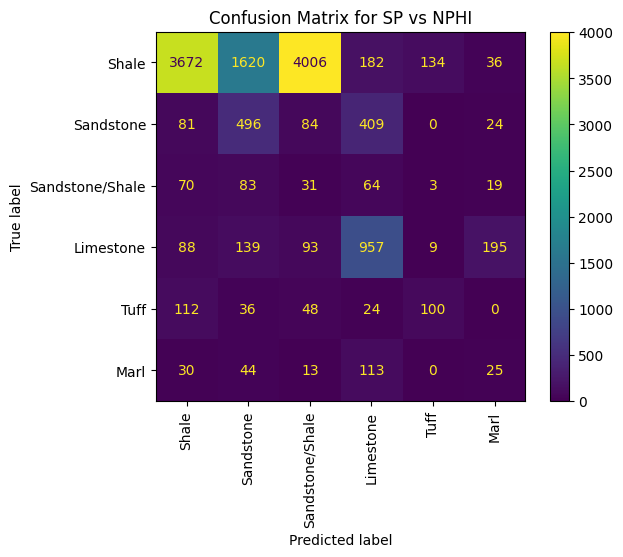

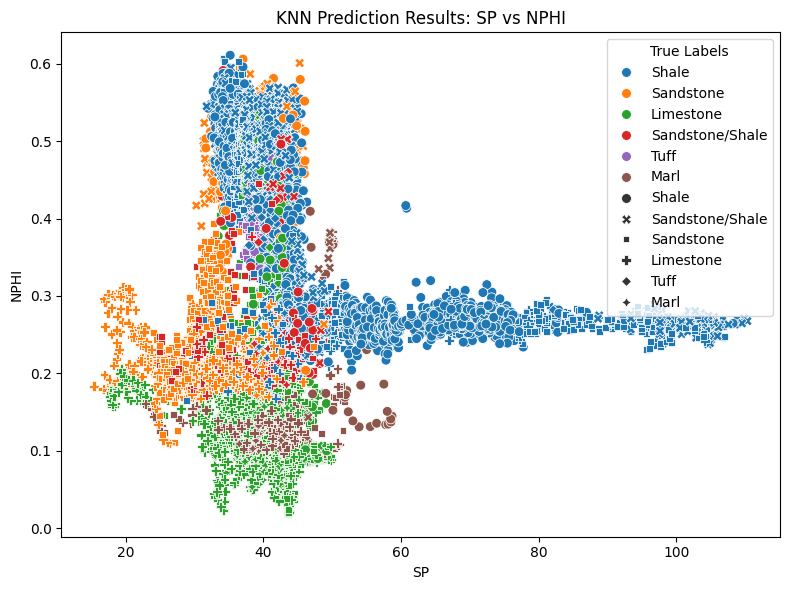

Training KNN for SP vs PEF...
Classification Report for SP vs PEF:
                 precision    recall  f1-score   support

      Limestone       0.19      0.30      0.23      1481
           Marl       0.00      0.00      0.00       225
      Sandstone       0.10      0.14      0.12      1094
Sandstone/Shale       0.02      0.36      0.03       270
          Shale       0.78      0.21      0.34      9650
           Tuff       0.03      0.01      0.01       320

       accuracy                           0.21     13040
      macro avg       0.19      0.17      0.12     13040
   weighted avg       0.61      0.21      0.29     13040



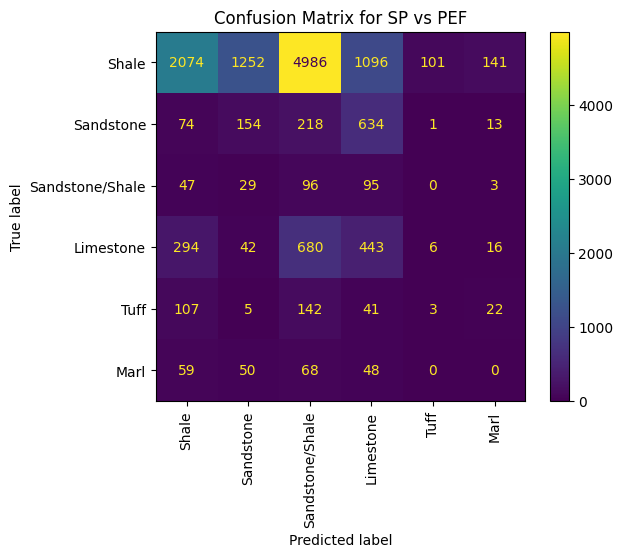

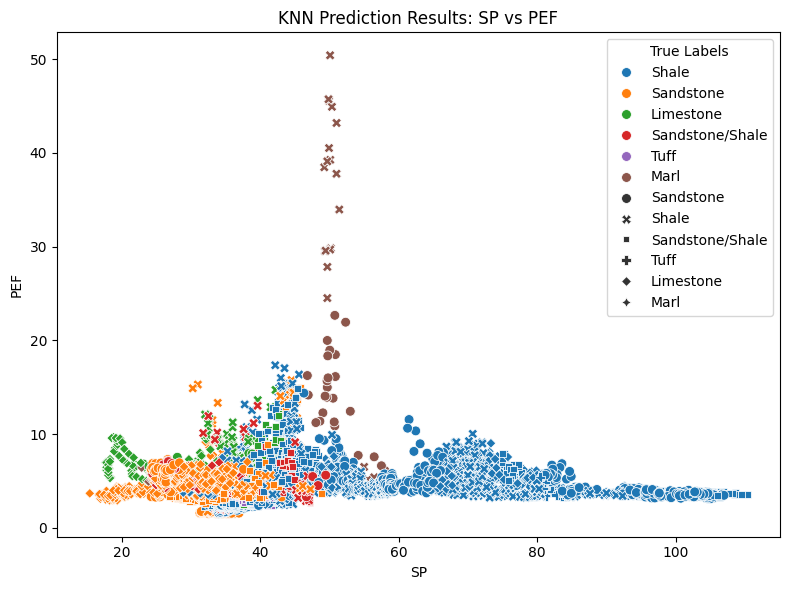

Training KNN for DTC vs PEF...
Classification Report for DTC vs PEF:
                 precision    recall  f1-score   support

      Limestone       0.81      0.41      0.54      1481
           Marl       0.28      0.36      0.31       225
      Sandstone       0.22      0.43      0.29      1094
Sandstone/Shale       0.01      0.24      0.03       270
          Shale       0.84      0.46      0.59      9650
           Tuff       0.42      0.03      0.05       320

       accuracy                           0.44     13040
      macro avg       0.43      0.32      0.30     13040
   weighted avg       0.75      0.44      0.53     13040



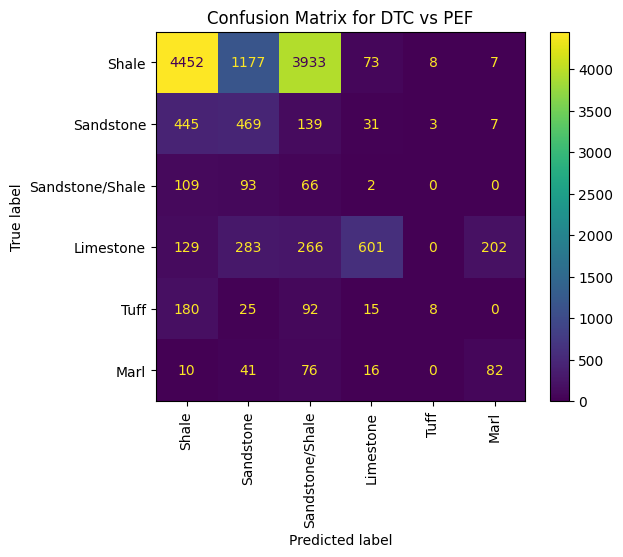

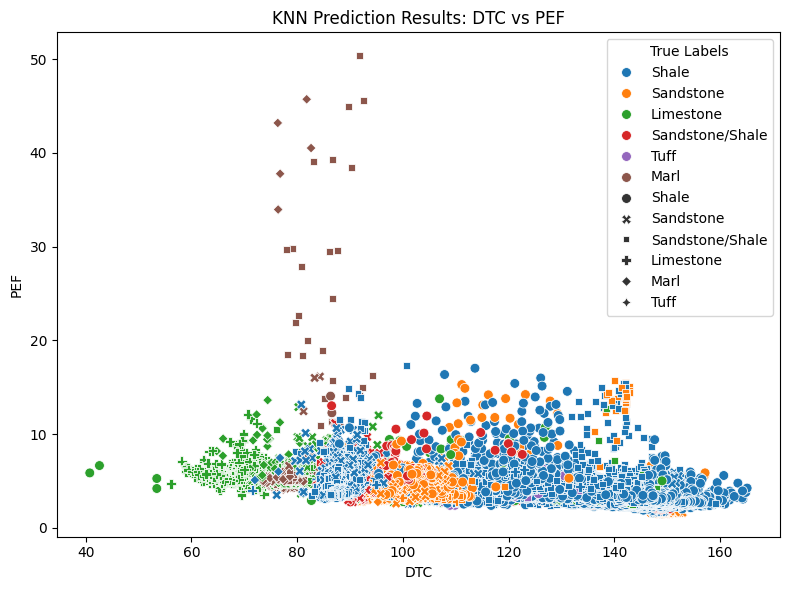

Training KNN for GR vs PEF...
Classification Report for GR vs PEF:
                 precision    recall  f1-score   support

      Limestone       0.82      0.83      0.82      1481
           Marl       0.04      0.07      0.05       225
      Sandstone       0.35      0.47      0.40      1094
Sandstone/Shale       0.05      0.54      0.09       270
          Shale       0.97      0.66      0.79      9650
           Tuff       0.05      0.02      0.03       320

       accuracy                           0.63     13040
      macro avg       0.38      0.43      0.36     13040
   weighted avg       0.85      0.63      0.71     13040



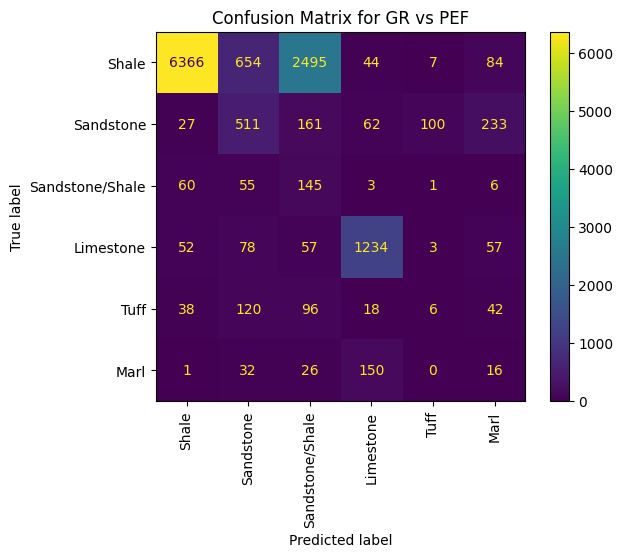

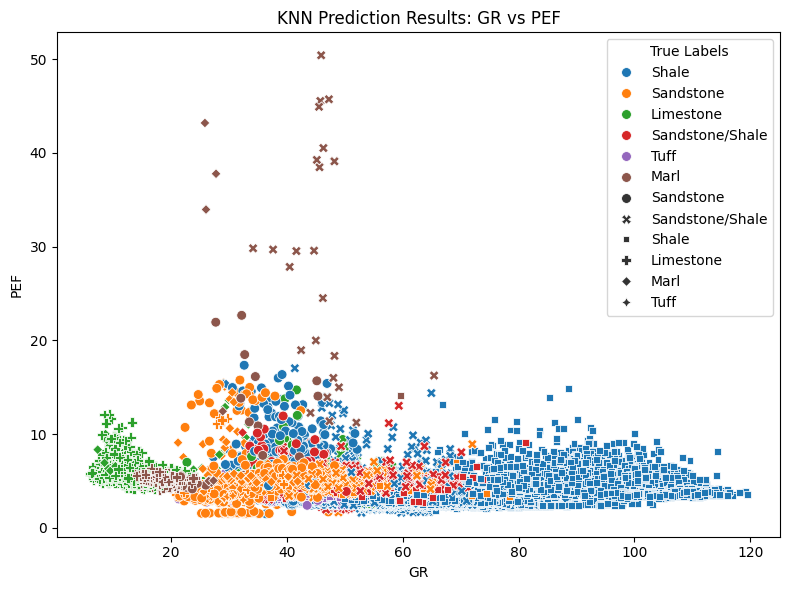

Training KNN for SP vs GR...
Classification Report for SP vs GR:
                 precision    recall  f1-score   support

      Limestone       0.84      0.83      0.84      1481
           Marl       0.25      0.15      0.18       225
      Sandstone       0.69      0.80      0.74      1094
Sandstone/Shale       0.03      0.55      0.06       270
          Shale       0.97      0.55      0.70      9650
           Tuff       0.32      0.07      0.11       320

       accuracy                           0.59     13040
      macro avg       0.52      0.49      0.44     13040
   weighted avg       0.88      0.59      0.68     13040



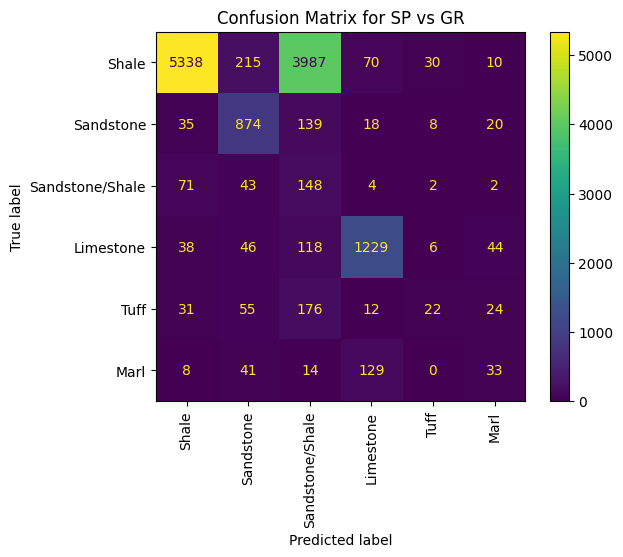

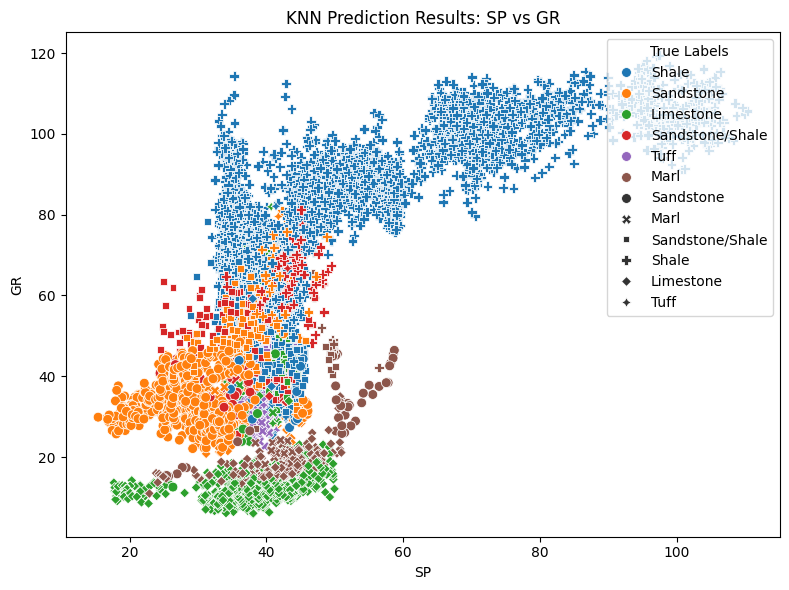

In [98]:
# Define feature pairs for training and evaluation
feature_pairs = [
    ('SP', 'DTC'),
    ('SP', 'NPHI'),
    ('SP', 'PEF'),
    ('DTC', 'PEF'),
    ('GR', 'PEF'),
    ('SP', 'GR')
]

# Function to train and evaluate KNN for lithology prediction with specified train/test splits
def train_knn_with_custom_split(X_train, y_train, X_test, y_test, feature_x, feature_y, n_neighbors=5):
    # Extract only the relevant features for this pair
    X_train_subset = X_train[[feature_x, feature_y]].dropna()
    y_train_subset = y_train[X_train_subset.index]
    X_test_subset = X_test[[feature_x, feature_y]].dropna()
    y_test_subset = y_test[X_test_subset.index]

    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_subset, y_train_subset)

    # Predict on test data
    y_pred = knn.predict(X_test_subset)

    # Evaluate model performance
    print(f"Classification Report for {feature_x} vs {feature_y}:")
    print(classification_report(y_test_subset, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_subset, y_pred, labels=y_train.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=y_train.unique())
    disp.plot(cmap="viridis", xticks_rotation='vertical')
    plt.title(f"Confusion Matrix for {feature_x} vs {feature_y}")
    plt.show()

    # Visualize predicted clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=feature_x,
        y=feature_y,
        hue=y_test_subset,  # True labels
        style=y_pred,  # Predicted labels
        palette='tab10',
        data=X_test_subset.assign(True_Label=y_test_subset, Pred_Label=y_pred),
        s=50
    )
    plt.title(f"KNN Prediction Results: {feature_x} vs {feature_y}")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(title='True Labels', loc='upper right')
    plt.tight_layout()
    plt.show()

# Perform KNN for each feature pair
for feature_x, feature_y in feature_pairs:
    print(f"Training KNN for {feature_x} vs {feature_y}...")
    train_knn_with_custom_split(X_train, y_train, X_test, y_test, feature_x, feature_y, n_neighbors=5)

**Since I had 6 input features, there would have been 15 different KNN plots, confusion matrices, and classification reports. This would have been far too much to interpret. To simplify this, I chose to perform KNN clustering on pairs where I visually saw clusters in the seaborn plots from earlier.**

  - **SP vs DTC: Generally low precision (except shale) and low recall (except sandstone) values, which is indicated by the overall accuracy of 0.35, which is quite low. I was more optimisitc for this one as I observed more distinct clusters than the other pairs, but the performance indicates that KNN was ineffective with these features.**
  - **SP vs NPHI: I have many of the same comments, as I did with SP vs DTC. I was optimistic based on visual clustering I saw, but in practice, the overall accuracy was still quite low (0.4). The only notable recall was shale at 0.91, this makes sense as shale was the most common in both training/testing.**
  - **SP vs PEF: I thought this might have been able to differentiate the lithology which corresponded to the PEF outliers, and perhaps some in the low PEF values, sorting by SP. However, this had the worst performance of 0.21, and the only notable precision value was shale again.**
  - **DTC vs PEF: This model had good precision values for limestone and shale, but still had relatively low accuracy overall (0.44). This was another where I thought it might classify the outliers effectively, but it did not in practice.**
  - **GR vs PEF: This model did the best with an overall accuracy of 0.63. It had relatively high precision and recall scores for limestone and shale, which corresponded to high f1-scores for those lithologies. This makes sense, as GR and PEF are most related to lithology, while the other logs are often influenced by formation characteristics, and the fluids they contain.**
  - **SP vs GR: I chose this one because they had the highest importance in my gradient booster classification model. The results were very similar to GR vs PEF, except that this did much better with sandstone. This indicates to me that GR is driving a lot of this accuracy, which is also consistent with my gradient booster classification model.**

### Support Vector Machine (SVM)

Classification Report:
                 precision    recall  f1-score   support

      Limestone       0.87      0.83      0.85      1481
           Marl       0.03      0.02      0.02       225
      Sandstone       0.72      0.87      0.79      1094
Sandstone/Shale       0.01      0.24      0.02       270
          Shale       0.93      0.36      0.52      9650
           Tuff       0.69      0.52      0.59       320

       accuracy                           0.45     13040
      macro avg       0.54      0.47      0.47     13040
   weighted avg       0.87      0.45      0.56     13040



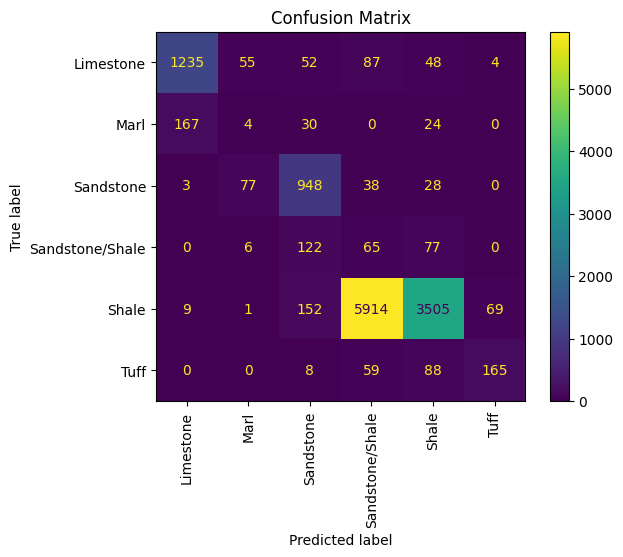

Number of support vectors: [ 709  407 1415 3554 2995  356]


In [99]:
# Step 1: Scale the features (SVM requires feature scaling for optimal performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train the SVM classifier
svm = SVC(kernel='rbf', random_state=42)  # You can experiment with different kernels (e.g., 'linear', 'poly')
svm.fit(X_train_scaled, y_train)

# Step 3: Make predictions on the test set
y_pred = svm.predict(X_test_scaled)

# Step 4: Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted(y_test.unique()))
disp.plot(cmap="viridis", xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Optional: Plot Support Vectors (for visual datasets)
print(f"Number of support vectors: {svm.n_support_}")

**SVM had similar results to the Gradient Boosting classifier. Based on f1-scores, it did the best with Limestone, Sandstone, Shale, and Tuff, while doing the worst wtih Marl and Sandstone/Shale. Another similarity was that shale had a great precision score, but a bad recall score. Overall the accuracy was 0.45, which was also similar.**

### Assignment Questions

Which method did you like the most?

**I liked Gradient Boosting the most because it did the best at classifying lithologies with less datapoints, and gives the feature importance plot which I thought was really useful for tying to the underlying physics of the logs.**


Which method did you like the least?

**I liked SVM the least because it did not give the feature importance, and performed worse than gradient boosting.**


How did you score these supervised models?  

**I chose to score these models using classification reports and confusion matrices. These are really intuitive and it allows you to see how well the model handles the various lithologies, both through the data and visually in the plot.**

Did the output align with your geologic understanding?

**These outputs alligned well with my geologic understanding. Gamma ray was by far the most important log, which is consistent with how it is used by interpreters for lithology classification. The importance of SP surprised me in this analysis, but as I mentioned, this data is dominated by shale and sandstone, which SP can differentiate based on permeability.**


Did you hyperparameter tune? Why or why not?

**I did not perform hyperparameter tuning for KNN, SVM, and Gradient Boosting, as the goal was to evaluate their baseline performance using default settings. Future work could include hyperparameter optimization to further improve model performance and refine the results.**


How did you split your data? and why does that make sense for this dataset?

**I chose to split my data on a well basis to reflect a realistic scenario where an interpreter marks lithologies in a few wells and applies the model elsewhere in the basin. This method, using two wells for training and one for testing, results in a 69/31% split, consistent with recommended practices for supervised methods. Additionally, I analyzed the lithology distribution in the data, as less common lithologies like marl and tuff may not perform as well as shale, which has the most training data.**


What did you want to learn more about?

**I want to explore Gradient Boosting, as I think it offers the most potential. If I was able to weight certain logs more, or remove others, I think I might be able to greatly increase its accuracy across lithologies.**


Did you pre-process your data?

**Yes, I imported .las files for each well, assigned well IDs, and combined them into a single dataframe after removing unnecessary columns. Rows with NaN values and unrealistic values (e.g., negative densities) were removed, and lithology codes were converted to intuitive text labels using a dictionary. This cleaning process resulted in 41,455 rows and 10 columns.**

Do all models require pre-processing?

**Yes, most models require preprocessing to ensure the data is clean, consistent, and formatted correctly for analysis. The extent of preprocessing depends on the model and dataset, but common steps include handling missing values, encoding categorical variables, and scaling features.**

